In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.4011942.datarmor0/parcels-502090/libparcels_random_01fa5c27-a4ad-44b8-99f1-2b9b1ad972b5.so


In [6]:
from dask.distributed import Client, LocalCluster

if True:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
else:    
    cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://10.148.1.16:55772 Dashboard: http://10.148.1.16:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
root_dir = '/home1/datawork/aponte/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time'])
df = p.df['time']
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity
time,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
t_start = df.index.min().compute()
t_end = df.index.max().compute()
delta_t = (t_end - t_start)/pd.Timedelta('1D') # in days

print(t_start, t_end, delta_t)

2011-11-15 00:00:00 2012-11-09 01:00:00 360.0416666666667


In [71]:
# geographical bins
dl = 1.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [72]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [73]:
df['velocity_amplitude'] = np.sqrt(df.zonal_velocity**2+df.meridional_velocity**2)

In [74]:
df = df.persist()

In [60]:
def add_geodata(df):

    df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)

    def build_polygon(r):
        lon0, lon1 = r.name[0].left, r.name[0].right
        lat0, lat1 = r.name[1].left, r.name[1].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(build_polygon, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    df['area'] = df.to_crs(crs = 'epsg:3857').area /1e6 / 1e4 # 100km^2 units
    
    return df

In [75]:
means = (df
         .groupby([df.lon_cut, df.lat_cut])
         .mean()
         .compute()
         #.to_frame()
        )



means = add_geodata(means)
#count['density'] = count['count']/count['area']

ds = (means
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

In [76]:
var = (df
         .groupby([df.lon_cut, df.lat_cut])
         .std()
         .compute()
         #.to_frame()
        )



variance = add_geodata(var)

ds_var = (variance
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

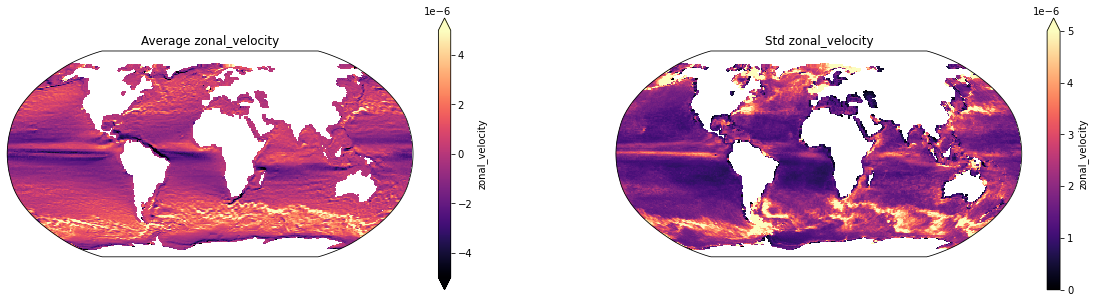

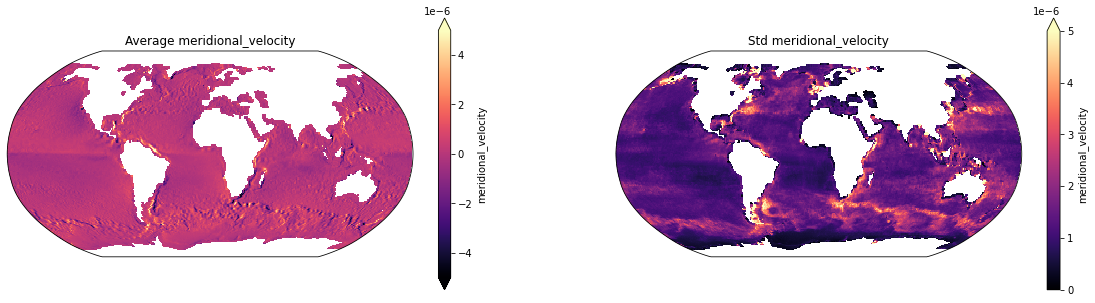

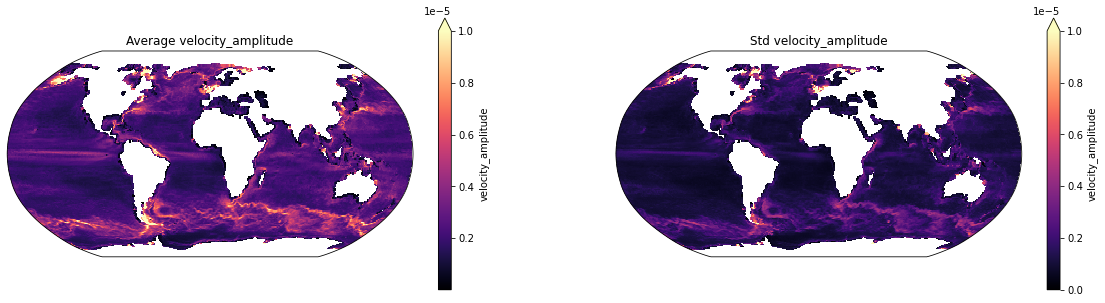

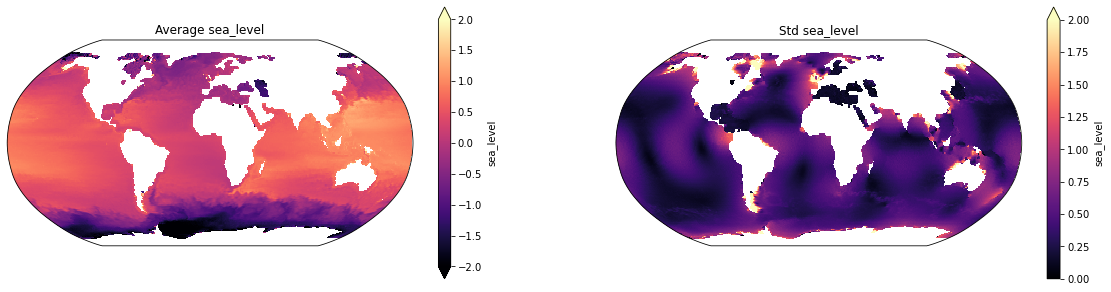

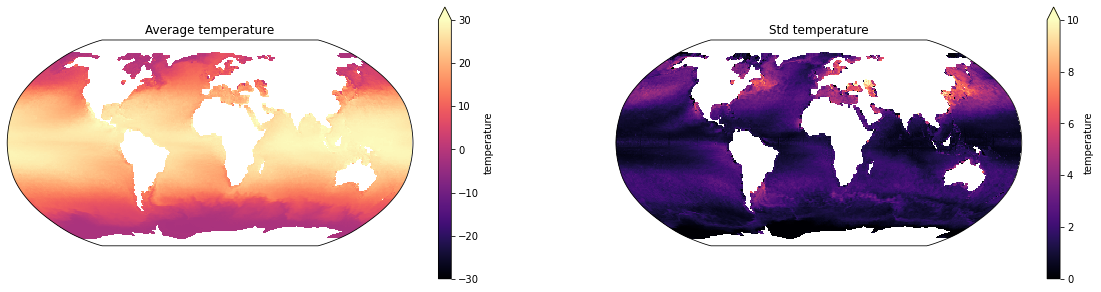

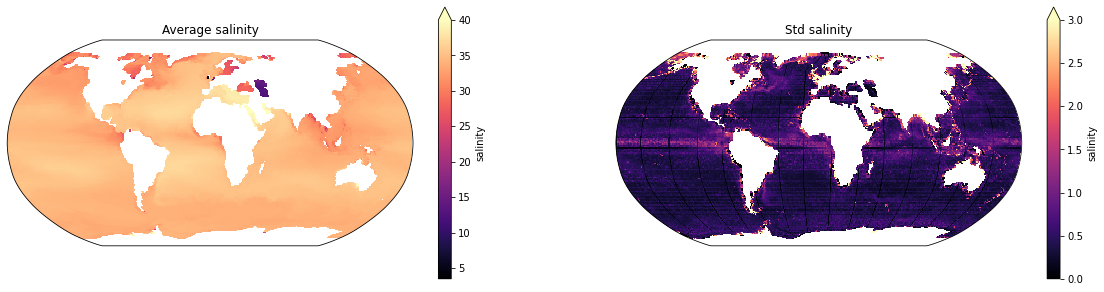

In [77]:
for V,vmax in zip(['zonal_velocity', 'meridional_velocity','velocity_amplitude','sea_level','temperature','salinity'],[[5e-6,5e-6],[5e-6,5e-6],[1e-5,1e-5],[2,2],[30,10],[40,3]]):
    figsize = (20,5)

    #crs = ccrs.Mollweide()
    crs = ccrs.Robinson()
    #crs = ccrs.EqualEarth()
    #crs = ccrs.Geodetic()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(121, projection=crs)

    ds[V].plot(x='lon', 
                     y='lat',
                     vmax=vmax[0],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Average '+V)
    ax = fig.add_subplot(122, projection=crs)

    ds_var[V].plot(x='lon', 
                     y='lat',
                     vmax=vmax[1],
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )
    plt.title('Std '+V)
    #ax.add_feature(cfeature.LAND, zorder=1)



In [ ]:
cluster.close()